In [1]:
import datetime as dt
import math
import os
import random
import sys
import time

import keras
import numpy as np
import pandas as pd
import quantstats as qs
import sklearn
import talib
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as yf
from fastai.tabular.core import df_shrink
from matplotlib import pyplot as plt

In [2]:
sys.path.append("..")

from src.configurations import shift_predictions
from src.create_backtest import (
    VaR,
    average_drawdown,
    average_drawdown_squared,
    beta,
    burke_ratio,
    calmar_ratio,
    classification_report_display,
    conditional_sharpe_ratio,
    confusion_matrix_display,
    cVaR,
    excess_var,
    financial_evaluation,
    gain_loss_ratio,
    hpm,
    information_ratio,
    kappa_three_ratio,
    lpm,
    max_drawdown,
    modigliani_ratio,
    omega_ratio,
    plain_classification_report,
    plot_charts,
    plot_init,
    plot_tables,
    second_2_minute_converter,
    sharpe_ratio,
    sortino_ratio,
    sterling_ratio,
    treynor_ratio,
    upside_potential_ratio,
    volatility,
)
from src.create_data import (
    CMF,
    HMA,
    adjustPrices,
    create_2d_data,
    create_all_indicators_in_talib,
    create_labels,
    number_null_and_nan,
    one_hot,
    pltcolor,
    reverse_one_hot,
    show_label_distribution,
    show_price_and_labels,
    show_prices,
    trendNormalizePrices,
    create_fundamental_data,
)
from src.create_neural_networks import (
    create_model_CNN_2D,
    create_model_GRU,
    create_model_LSTM,
    create_model_MLP,
    model_ho,
    model_train_test,
    show_epoch_and_score,
    ml_model_train_test,
)
from src.create_strategy import (
    create_bollinger_bands_predictions,
    create_buy_and_hold_predictions,
    create_ema_crossover_predictions,
    create_random_predictions,
    create_rsi_predictions,
    candlestick_pattern_trading,
    support_resistance_trading,
)
from src.feaure_engineering import (
    feature_selection,
    scaling,
)

<h1 style="font-size:40px;"> <center> CONSTANTS </center> </h1>

In [3]:
SEED = 42
TRAIN_TEST_EPOCH = 10
HO_EPOCH = 10
HO_TRIALS = 50
FINAL_MODEL_EPOCH = 20
EPOCH_BEFORE_OVERFIT = 30
MAX_ROW_AND_COLUMN_2_DISPLAY = 100
LENGTH = 30
METRIC = "f1_score"  # precision, recall, f1_score
TICKER = "SPY"
BENCHMARK_TICKER = "SPY"
START_DATE = "2000-01-01"
END_DATE = "2023-01-01"
INTERVAL = "1d"
SEE_ALL_EPOCHS = True
RUN_BUY_AND_HOLD = True
RUN_RANDOM_PREDICTION = True
RUN_RSI = True
RUN_EMA_CROSSOVER = True
RUN_BOLLINGER_BANDS = True
RUN_LGBM = True
RUN_XGBOOST = True
RUN_CATBOOST = True
RUN_MLP = True
RUN_LSTM = True
RUN_GRU = True
RUN_CNN = True
DATA_READY = True

In [4]:
backtest_configurations = {
    "ticker": TICKER,
    "benchmark_ticker": BENCHMARK_TICKER,
    "risk_free_rate": 0.05 / 252,
    "initial_capital": 1000,
    "commission": 1,
    "alpha": 0.05,
    "threshold": 0,
    "order": 1,
    "order_type": "market",  # "market" or "limit"
    "short": False,
    "short_fee": 1,
    "standard_take_profit": False,
    "trailing_take_profit": False,
    "take_profit_ratio": 100,
    "standard_stop_loss": False,
    "trailing_stop_loss": False,
    "stop_loss_ratio": 100,
    "leverage": 1,
    "miss_rate": 10,
    "show_initial_configuration": True,
    "show_tables": True,
    "show_charts": True,
    "show_time": True,
    "precision_point": 3,
}

In [5]:
pd.set_option("display.max_rows", MAX_ROW_AND_COLUMN_2_DISPLAY)
pd.set_option("display.max_columns", MAX_ROW_AND_COLUMN_2_DISPLAY)

In [6]:
notebook_start_time = time.time()

<h1 style="font-size:40px;"> <center> DATA READING </center> </h1>

In [7]:
try:
    indicators = pd.read_csv(
        f"../input/{TICKER}-all_indicators.csv", index_col="Date"
    )
    data = pd.read_csv(
        f"../input/{TICKER}-fully_processed.csv", index_col="Date"
    )
except:
    DATA_READY = False

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [8]:
if not DATA_READY:
    prices = yf.download(
        TICKER,
        start=START_DATE,
        end=END_DATE,
        interval=INTERVAL,
        progress=False,
        auto_adjust=True,
    )
    prices

In [9]:
if not DATA_READY:
    print(
        f"{prices.memory_usage().sum()/(1024**2)} MB is used before df_shrink"
    )
    prices = df_shrink(prices, int2uint=True)
    print(
        f"{prices.memory_usage().sum()/(1024**2)} MB is used after df_shrink"
    )

In [10]:
if not DATA_READY:
    show_prices(
        ticker=TICKER,
        df=prices,
        desc=f"Close Price of {TICKER}",
    )

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [11]:
if not DATA_READY:
    prices_with_label = create_labels(prices)
    prices_with_label.head(5)

In [12]:
if not DATA_READY:
    show_label_distribution(prices_with_label)

In [13]:
if not DATA_READY:
    show_price_and_labels(
        ticker=TICKER,
        df=prices_with_label,
        desc=f"Close Price with Labels of {TICKER}",
    )

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [14]:
if not DATA_READY:
    tn_prices_with_label = trendNormalizePrices(prices_with_label)
    tn_prices_with_label

In [15]:
if not DATA_READY:
    show_prices(
        ticker=TICKER,
        df=tn_prices_with_label,
        desc=f"Close TN-Price of {TICKER}",
    )

<h1 style="font-size:30px;"> <center> Adding Fundamental Data </center> </h1>

In [16]:
if not DATA_READY:
    prices_with_label = create_fundamental_data(prices_with_label)
    prices_with_label.fillna(0, inplace=True)

In [17]:
if not DATA_READY:
    tn_prices_with_label = create_fundamental_data(tn_prices_with_label)
    tn_prices_with_label.fillna(0, inplace=True)
    tn_prices_with_label

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [18]:
if not DATA_READY:
    prices_and_indicators_with_label = create_all_indicators_in_talib(
        df=prices_with_label, periods=list(range(6, 22))
    )

In [19]:
if not DATA_READY:
    tn_prices_and_indicators_with_label = (
        create_all_indicators_in_talib(
            df=tn_prices_with_label, periods=list(range(6, 22))
        )
    )

In [20]:
if not DATA_READY:
    tn_prices_and_indicators_with_label

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [21]:
if not DATA_READY:
    fundamental_columns = [
        "FED 2Y Interest Rate",
        "FED 10Y Interest Rate",
        "30-Year Fixed Rate Mortgage Average in the United States",
        "Unemployment Rate",
        "Real Gross Domestic Product",
        "Gross Domestic Product",
        "10-Year Breakeven Inflation Rate",
        "Median Sales Price of Houses Sold for the United States",
        "Personal Saving Rate",
        "Deposits, All Commercial Banks",
        "S&P 500",
        "Federal Debt: Total Public Debt as Percent of Gross Domestic Product",
        "Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma",
        "Consumer Loans: Credit Cards and Other Revolving Plans, All Commercial Banks",
        "Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average",
        "10-2 Year Yield Difference",
    ]
    price_columns = ["Open", "High", "Low", "Close", "Volume"]
    drop_columns = fundamental_columns + price_columns

In [22]:
if not DATA_READY:
    selected_features = feature_selection(
        tn_prices_and_indicators_with_label.loc[:"2015-01-01",].drop(
            columns=drop_columns
        ),
        method="ANOVA",
        selected_feature_count=150,
    )

In [23]:
if not DATA_READY:
    selected_indicators = {
        indicator.split("-")[0] for indicator in selected_features
    }
    selected_indicators

In [24]:
if not DATA_READY:
    columns = list(tn_prices_and_indicators_with_label.columns)
    selected_columns = []

    for column in columns:
        for selected_indicator in selected_indicators:
            if column.split("-")[0] == selected_indicator:
                selected_columns.append(column)
    selected_columns.extend(fundamental_columns)
    selected_columns.append("Label")

    tn_prices_and_indicators_with_label_and_fs = (
        tn_prices_and_indicators_with_label[selected_columns]
    )
    tn_prices_and_indicators_with_label_and_fs

<h1 style="font-size:30px;"> <center> Feature Scaling </center> </h1>

In [25]:
if not DATA_READY:
    scld_tn_prices_and_indicators_with_label_and_fs = scaling(
        tn_prices_and_indicators_with_label_and_fs,
        split_index=tn_prices_and_indicators_with_label_and_fs.index.get_loc(
            "2018-01-02"
        ),
    )

In [26]:
if not DATA_READY:
    scld_tn_prices_and_indicators_with_label_and_fs

In [27]:
if not DATA_READY:
    prices_and_indicators_with_label.to_csv(
        f"../input/{TICKER}-all_indicators.csv"
    )
    scld_tn_prices_and_indicators_with_label_and_fs.to_csv(
        f"../input/{TICKER}-fully_processed.csv"
    )

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 2000-05-12 to 2022-12-30
Columns: 257 entries, RSI-6 to Label
dtypes: float64(257)
memory usage: 11.2+ MB


In [29]:
rf_data_1d = []

for i in range(5):
    train = data.loc[
        (data.index >= f"{2000}") & (data.index <= f"{2018+i}")
    ]
    test = data.loc[
        (data.index >= f"{2018+i}") & (data.index <= f"{2019+i}")
    ]
    rf_data_1d.append([train, test])

In [30]:
rf_data_1d[0][0]

RSI-6   WILLR-6   STOCH-6  STOCHF-6     HMA-6    TEMA-6  \
Date                                                                     
2000-05-12  0.699108 -0.109378  0.589023  0.890622  0.030795  0.058420   
2000-05-15  0.776733 -0.042215  0.827296  0.957785  0.164386  0.168820   
2000-05-16  0.802838 -0.111554  0.925053  0.865793  0.258639  0.245989   
2000-05-17  0.660710 -0.320213  0.785762  0.418236  0.245185  0.217580   
2000-05-18  0.545264 -0.635425  0.577017  0.039086  0.143880  0.136069   
...              ...       ...       ...       ...       ...       ...   
2017-12-22  0.392609 -0.842048  0.131508  0.192604 -0.062750 -0.055669   
2017-12-26  0.335923 -0.928446  0.114994  0.108503 -0.091129 -0.098335   
2017-12-27  0.322350 -0.915377  0.071492  0.128039 -0.114544 -0.123322   
2017-12-28  0.392600 -0.791550  0.105870  0.494185 -0.114258 -0.118533   
2017-12-29  0.294726 -0.926724  0.092545  0.115166 -0.129963 -0.155919   

               CMO-6    MACD-6  STOCHRSI-6     CCI-6  PLUS_DI-6  MINUS_DI-6  \
Date                                                                          
2000-05-12  0.266610  0.155427    1.000000  0.634210   0.489678    0.334999   
2000-05-15  0.428248  0.250225    1.000000  0.660589   0.577478    0.270922   
2000-05-16  0.482605  0.326428    1.000000  0.582585   0.657648    0.234968   
2000-05-17  0.186655  0.312223    0.183741  0.227451   0.560576    0.304062   
2000-05-18 -0.053736  0.240160    0.000000 -0.112481   0.467590    0.356957   
...              ...       ...         ...       ...        ...         ...   
2017-12-22 -0.371605 -0.109600    0.000000 -0.582695   0.261735    0.578425   
2017-12-26 -0.489641 -0.157259    0.000000 -0.549301   0.231400    0.571722   
2017-12-27 -0.517905 -0.189933    0.000000 -0.433181   0.209131    0.549513   
2017-12-28 -0.371625 -0.193986    0.589224 -0.289395   0.194471    0.510992   
2017-12-29 -0.575425 -0.229739    0.000000 -0.414839   0.144928    0.533309   

            AROONOSC-6   ADOSC-6     CMF-6     RSI-7   WILLR-7   STOCH-7  \
Date                                                                       
2000-05-12    0.333333 -0.001317  0.062482  0.709096 -0.109378  0.543601   
2000-05-15    0.500000  0.001442  0.010539  0.779983 -0.042215  0.762331   
2000-05-16    0.666667  0.002629  0.074075  0.804141 -0.111554  0.851668   
2000-05-17    0.666667  0.001945  0.093629  0.683421 -0.320213  0.847122   
2000-05-18    0.666667 -0.000876  0.229866  0.581856 -0.528171  0.684153   
...                ...       ...       ...       ...       ...       ...   
2017-12-22   -0.666667 -0.067278 -0.164587  0.429848 -0.842048  0.129432   
2017-12-26   -0.833333 -0.045647 -0.335522  0.377660 -0.928446  0.098961   
2017-12-27   -1.000000 -0.038205 -0.308408  0.365092 -0.928869  0.100821   
2017-12-28   -0.833333 -0.011589  0.016859  0.422005 -0.833249  0.094856   
2017-12-29   -1.000000 -0.043597 -0.074189  0.334125 -0.937354  0.085796   

            STOCHF-7     HMA-7    TEMA-7     CMO-7    MACD-7  STOCHRSI-7  \
Date                                                                       
2000-05-12  0.890622  0.029891  0.051212  0.253085  0.158489    1.000000   
2000-05-15  0.957785  0.160235  0.158382  0.403951  0.244172    1.000000   
2000-05-16  0.888446  0.256559  0.238979  0.455367  0.316466    1.000000   
2000-05-17  0.614762  0.247192  0.221525  0.198441  0.309827    0.235022   
2000-05-18  0.040417  0.148289  0.149171 -0.017719  0.249684    0.000000   
...              ...       ...       ...       ...       ...         ...   
2017-12-22  0.157952 -0.063520 -0.053969 -0.341235 -0.096071    0.000000   
2017-12-26  0.085769 -0.094697 -0.097652 -0.452305 -0.142680    0.000000   
2017-12-27  0.105785 -0.119236 -0.125449 -0.479053 -0.176713    0.000000   
2017-12-28  0.252303 -0.116149 -0.124732 -0.357927 -0.185277    0.521943   
2017-12-29  0.115166 -0.129454 -0.161645 -0.544959 -0.221213    0.000000   

               CCI-7  PLUS_DI-7  MINUS_DI-7  A

In [31]:
rf_data_1d[0][1]

RSI-6   WILLR-6   STOCH-6  STOCHF-6     HMA-6    TEMA-6  \
Date                                                                     
2018-01-02  0.578728 -0.027681  0.210719  0.972319 -0.100743 -0.098492   
2018-01-03  0.717932 -0.050555  0.512327  0.949445 -0.016034 -0.007380   
2018-01-04  0.774397 -0.124025  0.718030  0.875975  0.077563  0.069026   
2018-01-05  0.849657 -0.027239  0.881507  0.969909  0.156503  0.154016   
2018-01-08  0.822713 -0.056159  0.960312  0.916497  0.188035  0.184840   
...              ...       ...       ...       ...       ...       ...   
2018-12-24  0.211276 -0.995628  0.020052  0.004372 -0.991695 -1.099983   
2018-12-26  0.687981 -0.171879  0.376373  1.000000 -0.722377 -0.599438   
2018-12-27  0.746087 -0.013232  0.837704  0.986768 -0.196261 -0.192974   
2018-12-28  0.762116 -0.174468  0.876940  0.825532  0.184772  0.044163   
2018-12-31  0.817778 -0.028382  0.900461  0.970435  0.355968  0.285215   

               CMO-6    MACD-6  STOCHRSI-6     CCI-6  PLUS_DI-6  MINUS_DI-6  \
Date                                                                          
2018-01-02  0.015947 -0.181869    1.000000  0.421123   0.114257    0.420444   
2018-01-03  0.305809 -0.093173    1.000000  0.935632   0.432889    0.335177   
2018-01-04  0.423384 -0.005966    1.000000  0.664524   0.593514    0.271472   
2018-01-05  0.580097  0.094614    1.000000  0.559548   0.640017    0.221308   
2018-01-08  0.523990  0.151164    0.900547  0.410654   0.554485    0.191732   
...              ...       ...         ...       ...        ...         ...   
2018-12-24 -0.749191 -1.126345    0.000000 -0.739176   0.279412    0.346867   
2018-12-26  0.243442 -0.700651    1.000000  0.247976   0.474733    0.250103   
2018-12-27  0.364435 -0.279643    1.000000  0.633306   0.517368    0.202211   
2018-12-28  0.397811  0.034891    1.000000  0.679022   0.643275    0.180238   
2018-12-31  0.513716  0.360334    1.000000  0.486518   0.591450    0.165718   

            AROONOSC-6   ADOSC-6     CMF-6     RSI-7   WILLR-7   STOCH-7  \
Date                                                                       
2018-01-02   -0.833333 -0.001353  0.268396  0.579925 -0.381346  0.188042   
2018-01-03    0.333333  0.049614  0.321113  0.709986 -0.050555  0.357843   
2018-01-04    0.500000  0.070829  0.354140  0.764422 -0.124025  0.606688   
2018-01-05    0.666667  0.105001  0.529233  0.838729 -0.027239  0.806811   
2018-01-08    0.666667  0.121511  0.524474  0.816047 -0.056159  0.906530   
...                ...       ...       ...       ...       ...       ...   
2018-12-24   -0.500000 -0.388321 -0.701794  0.251106 -0.995628  0.052874   
2018-12-26   -0.500000 -0.232681 -0.374531  0.684212 -0.171879  0.262822   
2018-12-27    0.333333 -0.062513 -0.160855  0.741220 -0.013232  0.561720   
2018-12-28    0.500000 -0.048786 -0.108389  0.756817 -0.174468  0.837536   
2018-12-31    0.500000  0.025003  0.084858  0.810913 -0.028382  0.912788   

            STOCHF-7     HMA-7    TEMA-7     CMO-7    MACD-7  STOCHRSI-7  \
Date                                                                       
2018-01-02  0.972319 -0.099353 -0.110371 -0.021828 -0.182879    1.000000   
2018-01-03  0.949445 -0.013451 -0.023039  0.254979 -0.105418    1.000000   
2018-01-04  0.875975  0.081445  0.055082  0.370833 -0.025781    1.000000   
2018-01-05  0.972761  0.161548  0.143340  0.528980  0.068455    1.000000   
2018-01-08  0.937961  0.193985  0.182281  0.480706  0.125903    0.912358   
...              ...       ...       ...       ...       ...         ...   
2018-12-24  0.004372 -0.973716 -1.116404 -0.721648 -1.106112    0.000000   
2018-12-26  0.828121 -0.699876 -0.666298  0.200124 -0.744202    1.000000   
2018-12-27  0.986768 -0.175687 -0.269644  0.321453 -0.367250    1.000000   
2018-12-28  0.825532  0.209888 -0.014358  0.354649 -0.070770    1.000000   
2018-12-31  0.971618  0.394151  0.246444  0.469780  0.242949    1.000000   

               CCI-7  PLUS_DI-7  MINUS_DI-7  A

<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [32]:
total_na_count = 0
for data in rf_data_1d:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


In [33]:
test_indices = []
for data in rf_data_1d:
    test_indices.extend(data[1].index)
indicators.index = pd.to_datetime(indicators.index)
backtest_configurations["ohlcv"] = indicators.loc[test_indices]

In [59]:
test_data = indicators.loc[test_indices]

<h1 style="font-size:60px;"> <center> STRATEGIES </center> </h1>

<h1 style="font-size:40px;"> <center> TECHNICAL ANALYSIS </center> </h1>

<h1 style="font-size:30px;"> <center> Random Trades </center> </h1>

In [43]:
if RUN_RANDOM_PREDICTION:
    random_prediction = create_random_predictions(
        indicators.loc[test_indices]
    )
    backtest_configurations["predictions"] = random_prediction
    metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.39 seconds.



<h1 style="font-size:30px;"> <center> RSI </center> </h1>

In [44]:
if RUN_RSI:
    rsi_prediction = create_rsi_predictions(
        indicators.loc[test_indices],
        period=14,
        buy_value=40,
        sell_value=60,
    )
    backtest_configurations["predictions"] = rsi_prediction
    metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.55 seconds.



<h1 style="font-size:30px;"> <center> EMA Cross-over </center> </h1>

In [46]:
if RUN_EMA_CROSSOVER:
    ema_crossover_prediction = create_ema_crossover_predictions(
        indicators.loc[test_indices]
    )
    backtest_configurations["predictions"] = ema_crossover_prediction
    metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.45 seconds.



<h1 style="font-size:30px;"> <center> Bollinger Bands </center> </h1>

In [48]:
if RUN_BOLLINGER_BANDS:
    bollinger_bands_prediction = create_bollinger_bands_predictions(
        indicators.loc[test_indices]
    )
    backtest_configurations["predictions"] = bollinger_bands_prediction
    metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.38 seconds.



<h1 style="font-size:30px;"> <center> Candlestick Pattern </center> </h1>

In [49]:
candlestick_prediction = candlestick_pattern_trading(
    indicators.loc[test_indices],
    buy_pattern="Bullish Harami",
    sell_pattern="Bearish Harami",
)
backtest_configurations["predictions"] = candlestick_prediction
metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.48 seconds.



<h1 style="font-size:30px;"> <center> Support Resistance Levels </center> </h1>

In [50]:
support_resistance_prediction = support_resistance_trading(
    indicators.loc[test_indices]
)
backtest_configurations["predictions"] = support_resistance_prediction
metrics = financial_evaluation(**backtest_configurations)


Backtest was completed in 0 minutes and 0.4 seconds.



<h1 style="font-size:40px;"> <center> MACHINE LEARNING </center> </h1>

<h1 style="font-size:30px;"> <center> LIGHTGBM </center> </h1>

In [40]:
if RUN_LGBM:
    results = ml_model_train_test("LIGHTGBM", rf_data_1d)
    print(f"\nMean {METRIC} score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    lgbm_prediction = np.concatenate(results[0])
    lgbm_prediction = shift_predictions(lgbm_prediction)

([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
plain_classification_report(test_data, lgbm_prediction)
classification_report_display(test_data, lgbm_prediction)
confusion_matrix_display(test_data, lgbm_prediction)

<h1 style="font-size:30px;"> <center> XGBOOST </center> </h1>

In [64]:
if RUN_XGBOOST:
    results = ml_model_train_test("XGBOOST", rf_data_1d)
    print(f"\nMean {METRIC} score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    xgboost_prediction = np.concatenate(results[0])
    xgboost_prediction = shift_predictions(xgboost_prediction)


Mean f1_score score: 0.43050118234176243

Completed in 0.28 minutes


              precision    recall  f1-score   support

        Hold       0.89      0.87      0.88      1114
         Buy       0.15      0.15      0.15        74
        Sell       0.09      0.11      0.10        71

    accuracy                           0.79      1259
   macro avg       0.37      0.38      0.38      1259
weighted avg       0.80      0.79      0.79      1259



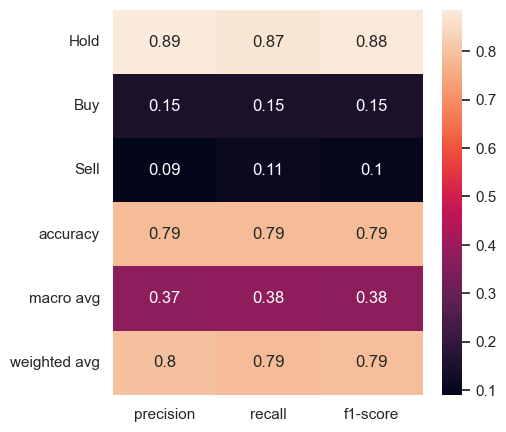

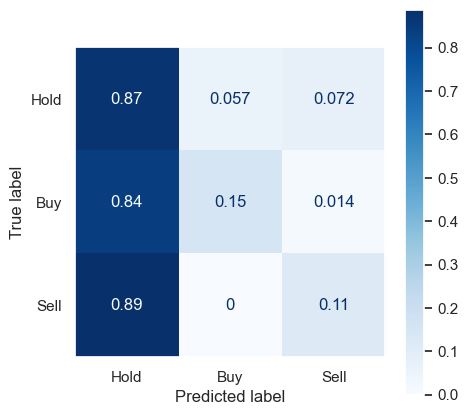

In [65]:
plain_classification_report(test_data, xgboost_prediction)
classification_report_display(test_data, xgboost_prediction)
confusion_matrix_display(test_data, xgboost_prediction)

<h1 style="font-size:30px;"> <center> CATBOOST </center> </h1>

In [66]:
RUN_CATBOOST = True
if RUN_CATBOOST:
    results = ml_model_train_test("CATBOOST", rf_data_1d)
    print(f"\nMean {METRIC} score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    catboost_prediction = np.concatenate(results[0])
    catboost_prediction = shift_predictions(catboost_prediction)

Learning rate set to 0.085374
0:	learn: 1.0549065	total: 95.8ms	remaining: 1m 35s
1:	learn: 1.0153756	total: 172ms	remaining: 1m 25s
2:	learn: 0.9782948	total: 266ms	remaining: 1m 28s
3:	learn: 0.9484304	total: 343ms	remaining: 1m 25s
4:	learn: 0.9199544	total: 422ms	remaining: 1m 24s
5:	learn: 0.8949753	total: 494ms	remaining: 1m 21s
6:	learn: 0.8745098	total: 570ms	remaining: 1m 20s
7:	learn: 0.8576833	total: 645ms	remaining: 1m 20s
8:	learn: 0.8395822	total: 732ms	remaining: 1m 20s
9:	learn: 0.8219421	total: 814ms	remaining: 1m 20s
10:	learn: 0.8073542	total: 892ms	remaining: 1m 20s
11:	learn: 0.7944507	total: 966ms	remaining: 1m 19s
12:	learn: 0.7802105	total: 1.05s	remaining: 1m 19s
13:	learn: 0.7678738	total: 1.14s	remaining: 1m 20s
14:	learn: 0.7564641	total: 1.23s	remaining: 1m 20s
15:	learn: 0.7462561	total: 1.33s	remaining: 1m 21s
16:	learn: 0.7358285	total: 1.44s	remaining: 1m 23s
17:	learn: 0.7265386	total: 1.52s	remaining: 1m 23s
18:	learn: 0.7174167	total: 1.62s	remaining

KeyboardInterrupt: 

In [ ]:
plain_classification_report(test_data, catboost_prediction)
classification_report_display(test_data, catboost_prediction)
confusion_matrix_display(test_data, catboost_prediction)

<h1 style="font-size:40px;"> <center> DEEP LEARNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [52]:
if RUN_MLP:
    results = model_train_test(
        "MLP", rf_data_1d, epochs=TRAIN_TEST_EPOCH, metric=METRIC
    )
    print(f"\nMean {METRIC} score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            f"{METRIC}",
        ],
    )
    mlp_prediction = np.concatenate(results[0])
    mlp_prediction = shift_predictions(mlp_prediction)


Mean f1_score score: 0.4287324058496632

Completed in 0.23 minutes


              precision    recall  f1-score   support

        Hold       0.88      0.57      0.69      1114
         Buy       0.14      0.42      0.21        74
        Sell       0.08      0.37      0.13        71

    accuracy                           0.55      1259
   macro avg       0.37      0.45      0.35      1259
weighted avg       0.79      0.55      0.63      1259



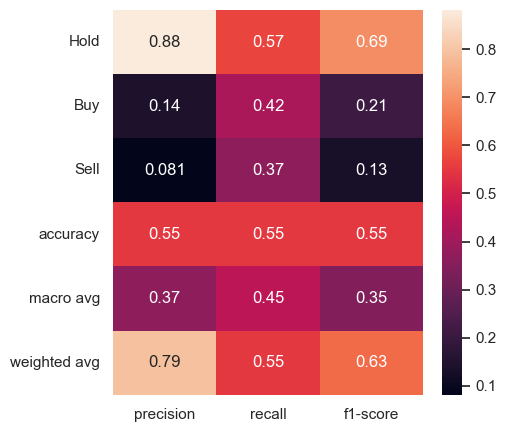

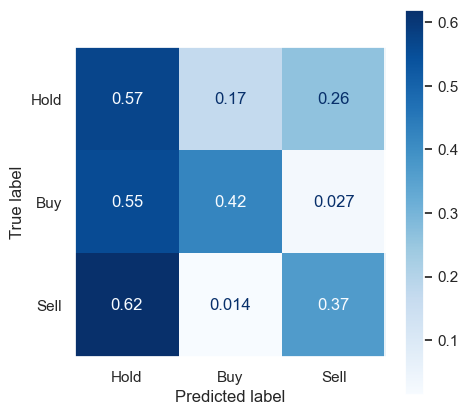

In [60]:
plain_classification_report(test_data, mlp_prediction)
classification_report_display(test_data, mlp_prediction)
confusion_matrix_display(test_data, mlp_prediction)

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
if RUN_LSTM:
    results = model_train_test(
        "LSTM", rf_data_1d, epochs=TRAIN_TEST_EPOCH, metric=METRIC
    )
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    lstm_prediction = np.concatenate(results[0])
    lstm_prediction = shift_predictions(lstm_prediction)

In [ ]:
plain_classification_report(test_data, lstm_prediction)
classification_report_display(test_data, lstm_prediction)
confusion_matrix_display(test_data, lstm_prediction)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
if RUN_GRU:
    results = model_train_test(
        "GRU", rf_data_1d, epochs=TRAIN_TEST_EPOCH, metric=METRIC
    )
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    gru_prediction = np.concatenate(results[0])
    gru_prediction = shift_predictions(gru_prediction)

In [ ]:
plain_classification_report(test_data, gru_prediction)
classification_report_display(test_data, gru_prediction)
confusion_matrix_display(test_data, gru_prediction)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
if RUN_CNN:
    results = model_train_test(
        "CNN_2D", rf_data_1d, epochs=TRAIN_TEST_EPOCH
    )
    print(f"\nMean f1-macro score: {results[1]}\n")
    print(f"Completed in {results[2]} minutes")
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    cnn_prediction = np.concatenate(results[0])
    cnn_prediction = shift_predictions(cnn_prediction)

In [ ]:
plain_classification_report(test_data, cnn_prediction)
classification_report_display(test_data, cnn_prediction)
confusion_matrix_display(test_data, cnn_prediction)

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
if RUN_MLP:
    mlp_parameter_space = {
        "activation_func": ["relu", "selu", "swish"],
        "dropout_rate": [0.1, 0.2, 0.3],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_mlp_parameters = model_ho(
        "MLP",
        datas_1d,
        epochs=HO_EPOCH,
        parameter_space=mlp_parameter_space,
        metric=METRIC,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
if RUN_LSTM:
    lstm_parameter_space = {
        "activation_func": ["tanh", "swish"],
        "dropout_rate": [0.2, 0.3, 0.4],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_lstm_parameters = model_ho(
        "LSTM",
        datas_2d,
        epochs=HO_EPOCH,
        parameter_space=lstm_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
if RUN_GRU:
    gru_parameter_space = {
        "activation_func": ["tanh", "swish"],
        "dropout_rate": [0.2, 0.3, 0.4],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_gru_parameters = model_ho(
        "GRU",
        datas_2d,
        epochs=HO_EPOCH,
        parameter_space=gru_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
if RUN_CNN:
    cnn2d_parameter_space = {
        "activation_func": ["relu", "selu", "swish"],
        "dropout_rate": [0.3, 0.4, 0.5],
        "optimizer_algo": ["adam", "adadelta", "rmsprop"],
        "batch_size": [32, 64, 256],
    }
    best_cnn2d_parameters = model_ho(
        "CNN_2D",
        rf_data_1d,
        epochs=HO_EPOCH,
        parameter_space=cnn2d_parameter_space,
        trial_number=HO_TRIALS,
    )

<h1 style="font-size:40px;"> <center> TUNED MODELS COMPARISONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
if RUN_MLP:
    if SEE_ALL_EPOCHS:
        results = model_train_test(
            "MLP",
            datas_1d,
            epochs=FINAL_MODEL_EPOCH,
            parameters=best_mlp_parameters,
            metric=METRIC,
        )
        history = results[3]
        show_epoch_and_score(
            history,
            [
                "loss",
                f"{METRIC}",
            ],
        )
    mlp_predictions = model_train_test(
        "MLP",
        datas_1d,
        epochs=EPOCH_BEFORE_OVERFIT,
        parameters=best_mlp_parameters,
        metric=METRIC,
    )[0]
    mlp_prediction = np.concatenate(mlp_predictions)
    mlp_prediction = shift_predictions(mlp_prediction)
    mlp_prediction

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
if RUN_LSTM:
    results = model_train_test(
        "LSTM",
        datas_2d,
        epochs=FINAL_MODEL_EPOCH,
        parameters=best_lstm_parameters,
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    lstm_predictions = model_train_test(
        "LSTM",
        datas_2d,
        epochs=EPOCH_BEFORE_OVERFIT,
        parameters=best_lstm_parameters,
    )[0]
    lstm_prediction = np.concatenate(lstm_predictions)
    lstm_prediction = shift_predictions(lstm_prediction)
    lstm_prediction

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
if RUN_GRU:
    results = model_train_test(
        "GRU",
        datas_2d,
        epochs=FINAL_MODEL_EPOCH,
        parameters=best_gru_parameters,
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    gru_predictions = model_train_test(
        "GRU",
        datas_2d,
        epochs=EPOCH_BEFORE_OVERFIT,
        parameters=best_gru_parameters,
    )[0]
    gru_prediction = np.concatenate(gru_predictions)
    gru_prediction = shift_predictions(gru_prediction)
    gru_prediction

<h1 style="font-size:30px;"> <center> CNN-2D </center> </h1>

In [ ]:
if RUN_CNN:
    results = model_train_test(
        "CNN_2D",
        datas_2d,
        epochs=FINAL_MODEL_EPOCH,
        parameters=best_cnn2d_parameters,
    )
    history = results[3]
    show_epoch_and_score(
        history,
        [
            "loss",
            "f1_score",
        ],
    )
    cnn2d_predictions = model_train_test(
        "CNN_2D",
        datas_2d,
        epochs=EPOCH_BEFORE_OVERFIT,
        parameters=best_cnn2d_parameters,
    )[0]
    cnn2d_prediction = np.concatenate(cnn2d_predictions)
    cnn2d_prediction = shift_predictions(cnn2d_prediction)
    cnn2d_prediction

<h1 style="font-size:40px;"> <center> FINAL MODEL OPTIMIZATION </center> </h1>

<h1 style="font-size:40px;"> <center> BACKTEST RESULTS OF THE FINAL MODEL </center> </h1>

<h1 style="font-size:40px;"> <center> CLASSIFICATION EVALUATION </center> </h1>

In [51]:
test_labels = prices_and_indicators_with_label.loc[test_indices]
test_labels.head(5)

NameError: name 'prices_and_indicators_with_label' is not defined

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
if RUN_LSTM:
    plain_classification_report(test_labels, lstm_prediction)
    classification_report_display(test_labels, lstm_prediction)
    confusion_matrix_display(test_labels, lstm_prediction)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
if RUN_GRU:
    plain_classification_report(test_labels, gru_prediction)
    classification_report_display(test_labels, gru_prediction)
    confusion_matrix_display(test_labels, gru_prediction)

<h1 style="font-size:30px;"> <center> CNN-2D </center> </h1>

In [ ]:
if RUN_CNN:
    plain_classification_report(test_labels, cnn2d_prediction)
    classification_report_display(test_labels, cnn2d_prediction)
    confusion_matrix_display(test_labels, cnn2d_prediction)

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

In [ ]:
test_prices = prices.loc[test_indices]
test_prices

<h1 style="font-size:30px;"> <center> Buy & Hold </center> </h1>

In [ ]:
if RUN_BUY_AND_HOLD:
    backtest_configurations["predictions"] = buy_and_hold_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> Random Prediction </center> </h1>

<h1 style="font-size:30px;"> <center> RSI </center> </h1>

In [ ]:
if RUN_RSI:
    backtest_configurations["predictions"] = rsi_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> EMA Crossover </center> </h1>

In [ ]:
if RUN_EMA_CROSSOVER:
    backtest_configurations["predictions"] = ema_crossover_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> Bollinger Bands </center> </h1>

In [ ]:
if RUN_BOLLINGER_BANDS:
    backtest_configurations["predictions"] = bollinger_bands_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
if RUN_MLP:
    backtest_configurations["predictions"] = mlp_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [ ]:
if RUN_LSTM:
    backtest_configurations["predictions"] = lstm_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

In [ ]:
if RUN_GRU:
    backtest_configurations["predictions"] = gru_prediction
    metrics = financial_evaluation(**backtest_configurations)

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [ ]:
if RUN_CNN:
    backtest_configurations["predictions"] = cnn2d_prediction
    metrics = financial_evaluation(**backtest_configurations)

In [ ]:
notebook_end_time = time.time()
print(
    f"Notebook run in {round(int(notebook_end_time - notebook_start_time) / 60, 2)} minutes"
)